# wikipedia hyperlink network visualization

data: https://snap.stanford.edu/data/wiki-topcats.html

source: Jure Leskovec, Stanford University

> This is a web graph of Wikipedia hyperlinks collected in September 2011. The network was constructed by first taking the largest strongly connected component of Wikipedia, then restricting to pages in the top set of categories (those with at least 100 pages), and finally taking the largest strongly connected component of the restricted graph.
 


## explore the data

the data rests in 3 text files of each ±40MB
- categories
    - a line looks like: Category:Category_name; (series of numbers)
    - Category:Buprestoidea; 301 302 303
    - the numbers presumably represent the pages in the category 
- page names
    - a line looks like: number Page_name
    - 0 Chiasmal syndrome
    - this represents the mappin of number to name
- reduced
    - a line consists of 2 tab separated numbers
    - 52	401135
    - the numbers presumably represent a hyperlink so __edges in the graph__


- count number of pages ( lines of page doc)
- show all page names in a category 

In [4]:
from pyspark import SparkContext
#import pyspark.sql.functions as F

In [44]:
try:
    sc.stop()
    sc = SparkContext('local')
except NameError:
    sc = SparkContext('local')

In [49]:
names = sc.textFile("../data/wiki-topcats-page-names.txt")
edges = sc.textFile("../data/wiki-topcats-reduced.txt")

In [8]:
print(names.count())

1791489


In [5]:
def getNameByNumber(num):
    num_str = str(num)+' '
    name_filter = names.filter(lambda x: num_str in x[:len(str(num))+1])\
        .map(lambda x: x[len(str(num))+1:])
    name = name_filter.collect()
    return name[0]
    
def getLinksByNumber(num):
    num_str = str(num)+'\t'
    edge_filter = edges.filter(lambda x: num_str in x[:len(str(num))+1])\
        .map(lambda x: x[len(str(num))+1:])
    links = edge_filter.collect()
    return links
def getNextNamesByNumber(num):
    next_nums = getLinksByNumber(num)
    names=[]
    for n in next_nums:
        names.append(getNameByNumber(n))
    return names
def hasLinks(num):
    # check getAllPagesWithLinks list in stead of whole doc
    num_str = str(num)+'\t'
    edge_filter = edges.filter(lambda x: num_str in x[:len(str(num))+1])
    if(edge_filter.count()==0):
        return False
    return True

def getAllPagesWithLinks():
    return


In [6]:
number = 8484
print(getNameByNumber(number))
if(hasLinks(number)):
    print(getNextNamesByNumber(number))
else:
    print("no links")

Neurology
no links


## display small example network

- start with a number
- get links
- draw edge from name to next names

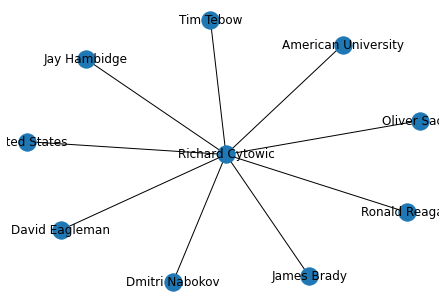

In [6]:
num_in = 62
name_in = getNameByNumber(num_in)
next_nums = getLinksByNumber(num_in)

import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for num in next_nums:  
    G.add_edge(name_in,getNameByNumber(num))

nx.draw(G, with_labels=True)
plt.show()



In [7]:


print(names.take(10))
#lineLengths = lines.map(lambda s: len(s))
#totalLength = lineLengths.reduce(lambda a, b: a + b)

#print(totalLength)

['0 Chiasmal syndrome', '1 Kleroterion', '2 Pinakion', '3 LyndonHochschildSerre spectral sequence', "4 Zariski's main theorem", '5 FultonHansen connectedness theorem', "6 Cayley's ruled cubic surface", '7 Annulus theorem', "8 Bing's recognition theorem", '9 BochnerMartinelli formula']


create network matrix & visualize


In [11]:
test=edges.take(1)
test2=test[0].split('\t')
print(test2)

['52', '401135']


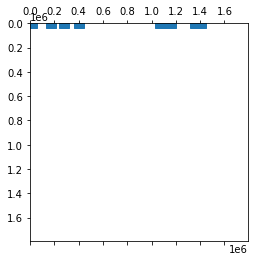

In [64]:
import matplotlib.pylab as plt
import numpy as np
import scipy.sparse as sp

B = sp.csr_matrix((1791488,1791488),dtype=np.int8)

sample =edges.take(10)
s_edges= sc.parallelize(sample)

split_edges= edges.map(lambda x: x.split('\t')).collect()

for x in split_edges:
    B[int(x[0]),int(x[1])]=1

plt.spy(B,markersize=2)